In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
! pip install keras-tuner

In [ ]:
from sklearn.model_selection import train_test_split
from keras import optimizers
from keras.models import Sequential, Model
from keras.layers import Dense, LSTM, Dropout
from sklearn.metrics import mean_squared_error
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import glob
from sklearn.preprocessing import MinMaxScaler
import matplotlib.cbook as cbook
import tensorflow as tf
import kerastuner as kt
from tensorflow.keras.losses import MeanAbsoluteError
import keras
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  


In [ ]:
path = r'/content/gdrive/MyDrive/transformed' # use your path
bus_all_files = glob.glob(path + "/bus/*.csv")
car_all_files = glob.glob(path + "/car/*.csv")
pedestrian_all_files = glob.glob(path + "/pedestrian/*.csv")
static_all_files = glob.glob(path + "/static/*.csv")
train_all_files = glob.glob(path + "/train/*.csv") 
all_files=[]
bus_all_files.sort()
all_files = all_files + bus_all_files + car_all_files + pedestrian_all_files + static_all_files + train_all_files


In [ ]:
li_train = []
for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    li_train.append(df)
frame = pd.concat(li_train, axis=0, ignore_index=True)
frame.head()

,CQI-0,CQI-1,CQI-2,CQI-3,CQI-4,DL_bitrate-0,DL_bitrate-1,DL_bitrate-2,DL_bitrate-3,DL_bitrate-4,...,SNR-1,SNR-2,SNR-3,SNR-4,UL_bitrate-0,UL_bitrate-1,UL_bitrate-2,UL_bitrate-3,UL_bitrate-4,DL_bitrate
0,7,7,10,7,7,0,0,310,3,3,...,7.0,7.0,10.0,10.0,0,0,14,7,7,1769
1,7,7,7,10,7,0,0,0,310,3,...,8.0,7.0,7.0,10.0,0,0,0,14,7,2272
2,7,7,7,7,10,0,0,0,0,310,...,8.0,8.0,7.0,7.0,0,0,0,0,14,2549
3,9,7,7,7,7,1757,0,0,0,0,...,10.0,8.0,8.0,7.0,68,0,0,0,0,2674
4,9,9,7,7,7,4216,1757,0,0,0,...,10.0,10.0,8.0,8.0,151,68,0,0,0,2393


In [ ]:
frame.shape

(173308, 46)

# Dealing with Nan Values

In [ ]:
frame.replace('-', np.NaN, inplace = True)
frame.isna().sum().sum()

1412508

In [ ]:
imputer = IterativeImputer(imputation_order='ascending',max_iter=10,random_state=42,n_nearest_features=None)
imputed_dataset = imputer.fit_transform(frame)
frame = pd.DataFrame(imputed_dataset,columns = frame.columns)
frame.isna().sum().sum()

0

In [ ]:
frame.describe()

,CQI-0,CQI-1,CQI-2,CQI-3,CQI-4,DL_bitrate-0,DL_bitrate-1,DL_bitrate-2,DL_bitrate-3,DL_bitrate-4,...,SNR-1,SNR-2,SNR-3,SNR-4,UL_bitrate-0,UL_bitrate-1,UL_bitrate-2,UL_bitrate-3,UL_bitrate-4,DL_bitrate
count,173308.000000,173308.000000,173308.000000,173308.000000,173308.000000,173308.000000,173308.000000,173308.000000,173308.000000,173308.000000,...,173308.000000,173308.000000,173308.000000,173308.000000,173308.000000,173308.000000,173308.000000,173308.000000,173308.000000,173308.000000
mean,7.802680,7.762008,7.773866,7.758458,7.766851,10808.171313,10810.279173,10812.429045,10815.209465,10817.850803,...,6.035456,5.847621,5.892696,5.974610,184.515366,184.544349,184.574797,184.610364,184.649508,10801.785665
std,2.553460,2.560483,2.558167,2.562291,2.561450,14141.293894,14144.785379,14147.370251,14151.142228,14155.225829,...,6.788329,6.749466,6.757639,6.782211,220.351485,220.395237,220.422796,220.457359,220.510902,13662.110094
min,-0.633076,1.000000,1.000000,1.000000,0.784749,0.000000,0.000000,0.000000,0.000000,0.000000,...,-30.000000,-30.000000,-30.000000,-30.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,7.000000,7.000000,7.000000,7.000000,7.000000,1386.000000,1386.000000,1386.000000,1386.000000,1386.000000,...,2.000000,2.000000,2.000000,2.000000,32.000000,32.000000,32.000000,32.000000,32.000000,1596.000000
50%,7.329336,7.186727,7.227594,7.177993,7.211425,5368.000000,5368.000000,5368.000000,5368.000000,5368.000000,...,7.434324,6.905200,7.000000,7.000000,107.000000,107.000000,107.000000,107.000000,107.000000,5611.000000
75%,9.000000,9.000000,9.000000,9.000000,9.000000,14774.000000,14774.000000,14785.000000,14785.000000,14785.000000,...,8.000000,7.588702,7.849509,8.000000,266.000000,266.000000,266.000000,266.000000,266.000000,14952.000000
max,15.000000,15.000000,15.000000,15.000000,15.000000,173016.000000,173016.000000,173016.000000,173016.000000,173016.000000,...,33.000000,33.000000,33.000000,33.697735,4178.000000,4178.000000,4178.000000,4178.000000,4178.000000,161878.000000


In [ ]:
frame.isna().sum().sum()

0

In [ ]:
# LOW - below 1000
# MEDIUM - between 1000 and 4000
# HIGH - greater than 4000

In [ ]:
frame_low = frame[frame['DL_bitrate']<=1000]
frame_medium = frame[(frame['DL_bitrate']>1000) & (frame['DL_bitrate']<=4000)]
frame_high = frame[frame['DL_bitrate']>4000]

In [ ]:
frame_low.shape

(32870, 46)

In [ ]:
frame_medium.shape

(40513, 46)

In [ ]:
frame_high.shape

(99925, 46)

In [ ]:
col_names_scaled =['CQI-0', 'CQI-1', 'CQI-2', 'CQI-3', 'CQI-4', 'DL_bitrate-0',
       'DL_bitrate-1', 'DL_bitrate-2', 'DL_bitrate-3', 'DL_bitrate-4', 'SNR-0', 'SNR-1', 'SNR-2', 'SNR-3', 'SNR-4', 'DL_bitrate']

# Random Split

## Low Throughput

In [ ]:
frame_low_train = frame_low.sample(frac = 0.7, random_state=0)
frame_low_test = frame_low.drop(frame_low_train.index)

In [ ]:
frame_low_train.head()

,CQI-0,CQI-1,CQI-2,CQI-3,CQI-4,DL_bitrate-0,DL_bitrate-1,DL_bitrate-2,DL_bitrate-3,DL_bitrate-4,...,SNR-1,SNR-2,SNR-3,SNR-4,UL_bitrate-0,UL_bitrate-1,UL_bitrate-2,UL_bitrate-3,UL_bitrate-4,DL_bitrate
17416,6.000000,6.000000,7.000000,7.000000,6.000000,156.0,413.0,0.0,548.0,391.0,...,3.000000,0.000000,0.000000,0.000000,6.0,14.0,0.0,27.0,19.0,511.0
164612,6.973947,6.912079,7.133442,7.280836,7.348298,0.0,0.0,0.0,0.0,0.0,...,7.041707,7.791906,7.644574,7.816520,0.0,0.0,0.0,0.0,0.0,7.0
148308,7.176964,7.134464,7.119683,7.096364,7.209592,335.0,816.0,268.0,290.0,1878.0,...,7.554923,7.075756,7.141029,7.663651,19.0,46.0,10.0,5.0,34.0,295.0
136596,7.502344,7.353321,7.565275,7.537274,7.595255,0.0,0.0,0.0,0.0,0.0,...,6.033224,6.017915,6.271430,6.618557,0.0,0.0,0.0,0.0,0.0,0.0
148634,7.176214,7.080507,7.161660,7.141208,7.190984,995.0,313.0,771.0,348.0,883.0,...,7.518596,7.153657,7.229638,7.451325,27.0,11.0,28.0,15.0,17.0,283.0


In [ ]:
frame_low_test.head()

,CQI-0,CQI-1,CQI-2,CQI-3,CQI-4,DL_bitrate-0,DL_bitrate-1,DL_bitrate-2,DL_bitrate-3,DL_bitrate-4,...,SNR-1,SNR-2,SNR-3,SNR-4,UL_bitrate-0,UL_bitrate-1,UL_bitrate-2,UL_bitrate-3,UL_bitrate-4,DL_bitrate
26,6.0,7.0,7.0,8.0,6.0,995.0,234.0,134.0,1185.0,705.0,...,2.0,3.0,2.0,2.0,38.0,10.0,4.0,26.0,28.0,368.0
27,6.0,6.0,7.0,7.0,8.0,749.0,995.0,234.0,134.0,1185.0,...,0.0,2.0,3.0,2.0,22.0,38.0,10.0,4.0,26.0,333.0
29,6.0,6.0,6.0,6.0,7.0,950.0,11.0,749.0,995.0,234.0,...,1.0,0.0,0.0,2.0,24.0,0.0,22.0,38.0,10.0,348.0
35,7.0,7.0,6.0,6.0,8.0,693.0,626.0,413.0,570.0,134.0,...,0.0,1.0,1.0,1.0,13.0,12.0,11.0,13.0,5.0,424.0
37,7.0,7.0,7.0,7.0,6.0,659.0,436.0,693.0,626.0,413.0,...,-1.0,0.0,0.0,1.0,14.0,8.0,13.0,12.0,11.0,330.0


In [ ]:
print(frame_low_train.shape)
print(frame_low_test.shape)

(23009, 46)
(9861, 46)


### With Scaling

#### MinMax Scaler

In [ ]:
df = frame_low_train[col_names_scaled]
min_max_scaler = MinMaxScaler()
# transform data
df_min_max_scaled = pd.DataFrame(min_max_scaler.fit_transform(df))

In [ ]:
X_train_min_max_scaler, X_valid_min_max_scaler, Y_train_min_max_scaler, Y_valid_min_max_scaler = train_test_split(df_min_max_scaled.iloc[:,:-1], df_min_max_scaled.iloc[:,-1:], test_size=0.3, random_state=0)
print('Train set shape', X_train_min_max_scaler.shape)
print('Validation set shape', X_valid_min_max_scaler.shape)
X_train_min_max_scaler.head()

Train set shape (16106, 15)
Validation set shape (6903, 15)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
22002,0.491432,0.437705,0.442980,0.438178,0.442533,0.000000,0.000000,0.000000,0.000000,0.000000,0.619884,0.601355,0.598982,0.585723,0.583443
21956,0.488265,0.500000,0.357143,0.285714,0.788959,0.003696,0.023653,0.020637,0.033074,0.041750,0.555556,0.555556,0.612903,0.603175,0.580868
5127,0.478625,0.406706,0.416329,0.412836,0.422115,0.000000,0.000000,0.000000,0.000000,0.000000,0.637583,0.608517,0.606705,0.600740,0.601133
1603,0.498366,0.435873,0.437126,0.436176,0.449646,0.003435,0.000990,0.000743,0.002124,0.002982,0.620180,0.597784,0.595607,0.592285,0.589331
20609,0.516664,0.443311,0.431140,0.427660,0.440492,0.001516,0.000000,0.000000,0.000000,0.000000,0.634076,0.589284,0.590824,0.584548,0.579941


In [ ]:
X_train_min_max_series = X_train_min_max_scaler.values.reshape((X_train_min_max_scaler.shape[0], X_train_min_max_scaler.shape[1], 1))
X_valid_min_max_series = X_valid_min_max_scaler.values.reshape((X_valid_min_max_scaler.shape[0], X_valid_min_max_scaler.shape[1], 1))
print('Train set shape', X_train_min_max_series.shape)
print('Validation set shape', X_valid_min_max_series.shape)

Train set shape (16106, 15, 1)
Validation set shape (6903, 15, 1)


### Hyper Parameter Tuning using Keras Auto Tuner

In [ ]:
mae = MeanAbsoluteError()
model_high = keras.Sequential()
model_high.add(keras.layers.Flatten(input_shape=(X_train_min_max_series.shape[1], X_train_min_max_series.shape[2])))
model_high.add(Dense(units=480, activation='relu'))
model_high.add(Dropout(rate=0))
model_high.add(tf.keras.layers.Dense(units=224, activation='relu'))
model_high.add(Dropout(rate=0))
model_high.add(tf.keras.layers.Dense(units=128, activation='relu'))
model_high.add(Dropout(rate=0))
model_high.add(Dense(1, kernel_initializer='normal', activation='linear'))
model_high.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),loss=mae,metrics=[mae])
model_high.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 15)                0         
                                                                 
 dense (Dense)               (None, 480)               7680      
                                                                 
 dropout (Dropout)           (None, 480)               0         
                                                                 
 dense_1 (Dense)             (None, 224)               107744    
                                                                 
 dropout_1 (Dropout)         (None, 224)               0         
                                                                 
 dense_2 (Dense)             (None, 128)               28800     
                                                                 
 dropout_2 (Dropout)         (None, 128)               0

In [ ]:
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=30, 
        verbose=1, mode='auto', restore_best_weights=True)
history=model_high.fit(X_train_min_max_series, Y_train_min_max_scaler, validation_data=(X_valid_min_max_series, Y_valid_min_max_scaler),
        callbacks=[monitor],verbose=1,epochs=500)

Epoch 1/500
504/504 [==============================] - 5s 3ms/step - loss: 0.2178 - mean_absolute_error: 0.2179 - val_loss: 0.1550 - val_mean_absolute_error: 0.1550
Epoch 2/500
504/504 [==============================] - 2s 4ms/step - loss: 0.1241 - mean_absolute_error: 0.1240 - val_loss: 0.1063 - val_mean_absolute_error: 0.1064
Epoch 3/500
504/504 [==============================] - 2s 3ms/step - loss: 0.1090 - mean_absolute_error: 0.1090 - val_loss: 0.1034 - val_mean_absolute_error: 0.1035
Epoch 4/500
504/504 [==============================] - 3s 5ms/step - loss: 0.1063 - mean_absolute_error: 0.1064 - val_loss: 0.1032 - val_mean_absolute_error: 0.1033
Epoch 5/500
504/504 [==============================] - 2s 4ms/step - loss: 0.1042 - mean_absolute_error: 0.1042 - val_loss: 0.0988 - val_mean_absolute_error: 0.0988
Epoch 6/500
504/504 [==============================] - 2s 3ms/step - loss: 0.1033 - mean_absolute_error: 0.1032 - val_loss: 0.1017 - val_mean_absolute_error: 0.1017
Epoch 7/50

In [ ]:
kt_train_pred_min_max_scaled = model_high.predict(X_train_min_max_scaler)
kt_valid_pred_min_max_scaled = model_high.predict(X_valid_min_max_scaler)
print('Train rmse:', np.sqrt(mean_squared_error(Y_train_min_max_scaler, kt_train_pred_min_max_scaled)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_valid_min_max_scaler, kt_valid_pred_min_max_scaled)))

Train rmse: 0.17472522510867036
Validation rmse: 0.17029904353370884


In [ ]:
df = frame_low_test[col_names_scaled]
df_test_scaled = pd.DataFrame(min_max_scaler.fit_transform(df))
X_test_scaled = df_test_scaled.iloc[:,:-1]
X_test_scaled.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,0.357143,0.428571,0.428571,0.500000,0.357143,0.014106,0.003666,0.002099,0.017551,0.009842,0.476190,0.507937,0.523810,0.507937,0.507937
1,0.357143,0.357143,0.428571,0.428571,0.500000,0.010619,0.015586,0.003666,0.001985,0.016543,0.476190,0.476190,0.507937,0.523810,0.507937
2,0.357143,0.357143,0.357143,0.357143,0.428571,0.013468,0.000172,0.011733,0.014737,0.003267,0.492063,0.492063,0.476190,0.476190,0.507937
3,0.428571,0.428571,0.357143,0.357143,0.500000,0.009825,0.009806,0.006470,0.008442,0.001871,0.476190,0.476190,0.492063,0.492063,0.492063
4,0.428571,0.428571,0.428571,0.428571,0.357143,0.009343,0.006830,0.010856,0.009272,0.005765,0.460317,0.460317,0.476190,0.476190,0.492063


In [ ]:
Y_test = frame_low_test.iloc[:,-1:]
Y_test.reset_index(drop=True,inplace=True)
X_pred_scaled = model_high.predict(X_test_scaled)
df_test_scaled[15]=X_pred_scaled
#Inverse Transforming the Predicted Values
df_test = pd.DataFrame(min_max_scaler.inverse_transform(df_test_scaled))
Y_pred = df_test.iloc[:,-1:]

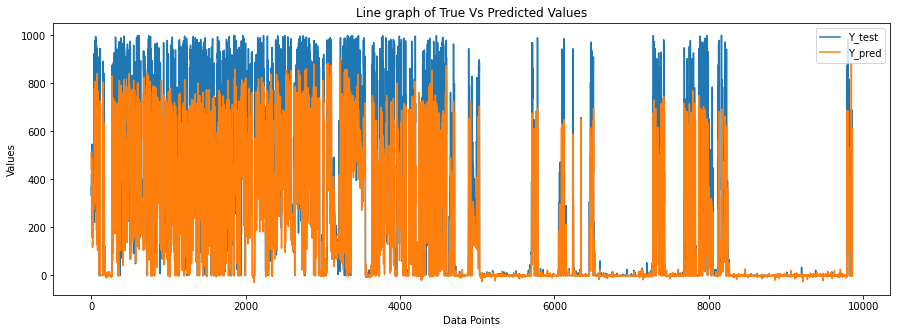

In [ ]:
fig, axes = plt.subplots(1, 1, sharex=True, sharey=True,figsize=(15,5))
ax3 = axes
ax3.plot(Y_test, label='Y_test')
ax3.plot(Y_pred, label='Y_pred')
ax3.legend(loc='best')
ax3.set_title('Line graph of True Vs Predicted Values')
ax3.set_xlabel('Data Points')
ax3.set_ylabel('Values')
plt.show()

In [ ]:
Y_test=Y_test['DL_bitrate']

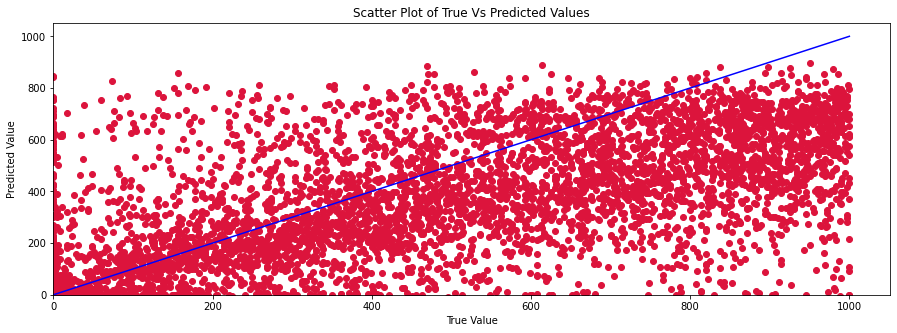

In [ ]:
fig, axes = plt.subplots(1, 1, sharex=True, sharey=True,figsize=(15,5))
ax3 = axes
ax3.scatter(Y_test, Y_pred[15], c='crimson')
p1 = max(max(Y_pred[15]), max(Y_test))
p2 = min(min(Y_pred[15]), min(Y_test))
ax3.plot([p1, p2], [p1, p2], 'b-')
ax3.set(xlim=(0, None),ylim=(0, None), title='Scatter Plot of True Vs Predicted Values', xlabel='True Value', ylabel='Predicted Value')
plt.show()

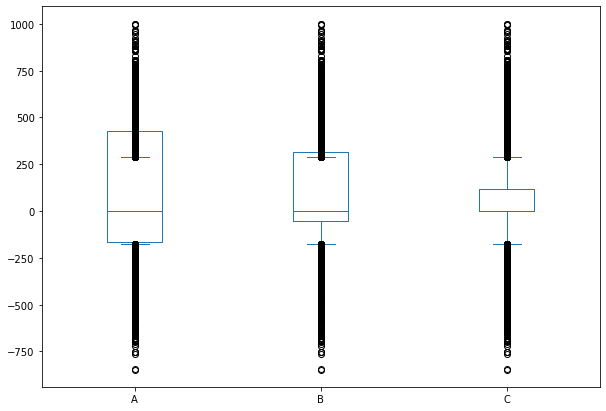

In [ ]:
a=Y_test.subtract(Y_pred[15])
stats = {}
# Compute the boxplot stats (as in the default matplotlib implementation)
stats['A'] = cbook.boxplot_stats(a, labels='A')[0]
stats['B'] = cbook.boxplot_stats(a, labels='B')[0]
stats['C'] = cbook.boxplot_stats(a, labels='C')[0]

# For box A compute the 1st and 99th percentiles
stats['A']['q1'], stats['A']['q3'] = np.percentile(a, [5, 95])
# For box B compute the 10th and 90th percentiles
stats['B']['q1'], stats['B']['q3'] = np.percentile(a, [10, 90])
# For box C compute the 25th and 75th percentiles (matplotlib default)
stats['C']['q1'], stats['C']['q3'] = np.percentile(a, [25, 75])

#fig = plt.figure(figsize =(10, 7))
fig, ax = plt.subplots(1, 1, figsize = (10,7))
# Plot boxplots from our computed statistics
bp = ax.bxp([stats['A'], stats['B'], stats['C']], positions=range(3))

# Colour the lines in the boxplot blue
for element in bp.keys():
    plt.setp(bp[element], color='C0')

In [ ]:
Y_pred=Y_pred[15]

In [ ]:
# calculate MAE
error = mae(Y_test, Y_pred)

# display
print("Mean absolute error : " + str(error))
print(f"Decimal Representation: {error:.20f}")

Mean absolute error : tf.Tensor(108.03492736816406, shape=(), dtype=float64)
Decimal Representation: 108.03492736816406250000


In [ ]:
# Mean Absolute Percentage Error
error = mean_absolute_percentage_error(Y_test, Y_pred)
print(error)

print(f" {error:.5f}")

2.046231016942025e+16
 20462310169420248.00000


In [ ]:
# Relative Absolute Error
# (|y1-y2|)/(|y1_mean-y1|)
def relative_absolute_error(y_true, y_pred):
  y1=y_true.to_numpy()
  y2=y_pred.to_numpy()
  num = np.sum(np.absolute(np.array(y1) - np.array(y2)))
  deno = np.sum(np.absolute(y2-np.mean(y1)))
  return (num/deno)
relative_absolute_error(Y_test, Y_pred)

0.45781255691038714

In [ ]:
# Root Relative Squared Error
# (|y1-y2|^2)/(|y1_mean-y1|^2)
def rrse(y_true, y_pred):
  y1=y_true.to_numpy()
  y2=y_pred.to_numpy()
  num = np.sum(np.square(np.absolute(np.array(y1) - np.array(y2))))
  deno = np.sum(np.square(np.absolute(y2-np.mean(y1))))
  return (num/deno)
rrse(Y_test, Y_pred)

0.5706286645526024

# Random Split

## Medium Throughput

In [ ]:
frame_medium_train = frame_medium.sample(frac = 0.7, random_state=0)
frame_medium_test = frame_medium.drop(frame_medium_train.index)

In [ ]:
frame_medium_train.head()

,CQI-0,CQI-1,CQI-2,CQI-3,CQI-4,DL_bitrate-0,DL_bitrate-1,DL_bitrate-2,DL_bitrate-3,DL_bitrate-4,...,SNR-1,SNR-2,SNR-3,SNR-4,UL_bitrate-0,UL_bitrate-1,UL_bitrate-2,UL_bitrate-3,UL_bitrate-4,DL_bitrate
130229,7.000000,7.000000,7.000000,7.000000,7.000000,883.0,1129.0,1744.0,1353.0,1151.0,...,4.000000,3.000000,3.000000,4.000000,17.0,45.0,32.0,25.0,22.0,1757.0
132909,9.000000,9.000000,9.000000,9.000000,9.000000,4775.0,7280.0,4932.0,5055.0,3355.0,...,4.000000,4.000000,4.000000,4.000000,87.0,135.0,91.0,163.0,69.0,3808.0
66478,7.151508,7.134263,7.303196,7.163615,7.010514,1878.0,905.0,391.0,78.0,257.0,...,7.944702,7.353061,6.605072,6.949846,34.0,14.0,11.0,2.0,8.0,1276.0
148761,7.180300,7.177610,7.207836,7.120676,7.104209,1834.0,1756.0,1767.0,905.0,1858.0,...,7.754284,7.076722,6.896782,7.143834,34.0,32.0,33.0,17.0,73.0,1106.0
7364,5.000000,12.000000,11.000000,11.000000,8.000000,1409.0,2784.0,3478.0,3042.0,3858.0,...,8.000000,8.000000,8.000000,8.000000,79.0,134.0,199.0,61.0,72.0,1809.0


In [ ]:
frame_medium_test.head()

,CQI-0,CQI-1,CQI-2,CQI-3,CQI-4,DL_bitrate-0,DL_bitrate-1,DL_bitrate-2,DL_bitrate-3,DL_bitrate-4,...,SNR-1,SNR-2,SNR-3,SNR-4,UL_bitrate-0,UL_bitrate-1,UL_bitrate-2,UL_bitrate-3,UL_bitrate-4,DL_bitrate
5,9.0,9.0,9.0,7.0,7.0,2874.0,4216.0,1757.0,0.0,0.0,...,10.0,10.0,10.0,8.0,53.0,151.0,68.0,0.0,0.0,2151.0
10,7.0,9.0,7.0,7.0,8.0,1666.0,2807.0,2382.0,1386.0,2516.0,...,9.0,9.0,12.0,10.0,60.0,52.0,45.0,26.0,47.0,2462.0
11,7.0,7.0,9.0,7.0,7.0,1107.0,1666.0,2807.0,2382.0,1386.0,...,8.0,9.0,9.0,12.0,52.0,60.0,52.0,45.0,26.0,2549.0
13,7.0,7.0,7.0,7.0,9.0,2169.0,3824.0,1107.0,1666.0,2807.0,...,8.0,8.0,8.0,9.0,78.0,75.0,52.0,60.0,52.0,1815.0
14,9.0,7.0,7.0,7.0,7.0,2874.0,2169.0,3824.0,1107.0,1666.0,...,8.0,8.0,8.0,8.0,54.0,78.0,75.0,52.0,60.0,1462.0


### With Scaling

#### MinMax Scaler

In [ ]:
df = frame_medium_train[col_names_scaled]
min_max_scaler = MinMaxScaler()
# transform data
df_min_max_scaled = pd.DataFrame(min_max_scaler.fit_transform(df))

In [ ]:
X_train_min_max_scaler, X_valid_min_max_scaler, Y_train_min_max_scaler, Y_valid_min_max_scaler = train_test_split(df_min_max_scaled.iloc[:,:-1], df_min_max_scaled.iloc[:,-1:], test_size=0.3, random_state=0)
print('Train set shape', X_train_min_max_scaler.shape)
print('Validation set shape', X_valid_min_max_scaler.shape)
X_train_min_max_scaler.head()

Train set shape (19851, 15)
Validation set shape (8508, 15)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
24469,0.428571,0.428571,0.428571,0.428571,0.428571,0.023053,0.011989,0.021684,0.009670,0.023972,0.383333,0.389831,0.383333,0.423729,0.416667
26120,0.142857,0.357143,0.357143,0.357143,0.357143,0.015039,0.017626,0.012422,0.017567,0.000000,0.433333,0.457627,0.450000,0.457627,0.450000
19277,0.285714,0.285714,0.285714,0.285714,0.285714,0.015754,0.047073,0.048249,0.026403,0.028120,0.433333,0.440678,0.383333,0.389831,0.416667
4655,0.071429,0.142857,0.285714,0.428571,0.428571,0.027512,0.011274,0.001199,0.006443,0.041254,0.500000,0.508475,0.600000,0.610169,0.683333
25810,0.441583,0.438634,0.441880,0.441093,0.442956,0.040679,0.067034,0.062131,0.032975,0.037540,0.652666,0.636516,0.619372,0.630899,0.624160


In [ ]:
X_train_min_max_series = X_train_min_max_scaler.values.reshape((X_train_min_max_scaler.shape[0], X_train_min_max_scaler.shape[1], 1))
X_valid_min_max_series = X_valid_min_max_scaler.values.reshape((X_valid_min_max_scaler.shape[0], X_valid_min_max_scaler.shape[1], 1))
print('Train set shape', X_train_min_max_series.shape)
print('Validation set shape', X_valid_min_max_series.shape)

Train set shape (19851, 15, 1)
Validation set shape (8508, 15, 1)


### Hyper Parameter Tuning using Keras Auto Tuner

In [ ]:
mae = MeanAbsoluteError()
model_high = keras.Sequential()
model_high.add(keras.layers.Flatten(input_shape=(X_train_min_max_series.shape[1], X_train_min_max_series.shape[2])))
model_high.add(Dense(units=320, activation='relu'))
model_high.add(Dropout(rate=0))
model_high.add(tf.keras.layers.Dense(units=256, activation='relu'))
model_high.add(Dropout(rate=0))
model_high.add(tf.keras.layers.Dense(units=64, activation='relu'))
model_high.add(Dropout(rate=0))
model_high.add(Dense(1, kernel_initializer='normal', activation='linear'))
model_high.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),loss=mae,metrics=[mae])
model_high.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 15)                0         
                                                                 
 dense_4 (Dense)             (None, 320)               5120      
                                                                 
 dropout_3 (Dropout)         (None, 320)               0         
                                                                 
 dense_5 (Dense)             (None, 256)               82176     
                                                                 
 dropout_4 (Dropout)         (None, 256)               0         
                                                                 
 dense_6 (Dense)             (None, 64)                16448     
                                                                 
 dropout_5 (Dropout)         (None, 64)               

In [ ]:
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=30, 
        verbose=1, mode='auto', restore_best_weights=True)
history=model_high.fit(X_train_min_max_series, Y_train_min_max_scaler, validation_data=(X_valid_min_max_series, Y_valid_min_max_scaler),
        callbacks=[monitor],verbose=1,epochs=500)

Epoch 1/500
621/621 [==============================] - 3s 3ms/step - loss: 0.2415 - mean_absolute_error: 0.2415 - val_loss: 0.2062 - val_mean_absolute_error: 0.2062
Epoch 2/500
621/621 [==============================] - 2s 3ms/step - loss: 0.1960 - mean_absolute_error: 0.1960 - val_loss: 0.1885 - val_mean_absolute_error: 0.1885
Epoch 3/500
621/621 [==============================] - 2s 3ms/step - loss: 0.1891 - mean_absolute_error: 0.1892 - val_loss: 0.1869 - val_mean_absolute_error: 0.1869
Epoch 4/500
621/621 [==============================] - 2s 4ms/step - loss: 0.1876 - mean_absolute_error: 0.1876 - val_loss: 0.1860 - val_mean_absolute_error: 0.1860
Epoch 5/500
621/621 [==============================] - 2s 4ms/step - loss: 0.1870 - mean_absolute_error: 0.1870 - val_loss: 0.1838 - val_mean_absolute_error: 0.1838
Epoch 6/500
621/621 [==============================] - 2s 4ms/step - loss: 0.1861 - mean_absolute_error: 0.1861 - val_loss: 0.1832 - val_mean_absolute_error: 0.1832
Epoch 7/50

In [ ]:
kt_train_pred_min_max_scaled = model_high.predict(X_train_min_max_scaler)
kt_valid_pred_min_max_scaled = model_high.predict(X_valid_min_max_scaler)
print('Train rmse:', np.sqrt(mean_squared_error(Y_train_min_max_scaler, kt_train_pred_min_max_scaled)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_valid_min_max_scaler, kt_valid_pred_min_max_scaled)))

Train rmse: 0.232259925521894
Validation rmse: 0.23221057213452012


In [ ]:
df = frame_medium_test[col_names_scaled]
df_test_scaled = pd.DataFrame(min_max_scaler.fit_transform(df))
X_test_scaled = df_test_scaled.iloc[:,:-1]
X_test_scaled.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,0.571429,0.571429,0.571429,0.428571,0.428571,0.069228,0.101554,0.035975,0.000000,0.000000,0.645491,0.615154,0.615547,0.605350,0.534485
1,0.428571,0.571429,0.428571,0.428571,0.500000,0.040130,0.067614,0.048771,0.030007,0.026884,0.606102,0.595912,0.595313,0.646892,0.575278
2,0.428571,0.428571,0.571429,0.428571,0.428571,0.026665,0.040130,0.057473,0.051571,0.014810,0.606102,0.576670,0.595313,0.584579,0.616070
3,0.428571,0.428571,0.428571,0.428571,0.571429,0.052246,0.092111,0.022666,0.036069,0.029993,0.606102,0.576670,0.575078,0.563808,0.554881
4,0.571429,0.428571,0.428571,0.428571,0.428571,0.069228,0.052246,0.078296,0.023967,0.017802,0.625797,0.576670,0.575078,0.563808,0.534485


In [ ]:
df = frame_medium_test[col_names_scaled]
df_test_scaled = pd.DataFrame(min_max_scaler.fit_transform(df))
X_test_scaled = df_test_scaled.iloc[:,:-1]
X_test_scaled.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,0.571,0.571,0.571,0.429,0.429,0.069,0.102,0.036,0.000,0.000,0.645,0.615,0.616,0.605,0.534
1,0.429,0.571,0.429,0.429,0.500,0.040,0.068,0.049,0.030,0.027,0.606,0.596,0.595,0.647,0.575
2,0.429,0.429,0.571,0.429,0.429,0.027,0.040,0.057,0.052,0.015,0.606,0.577,0.595,0.585,0.616
3,0.429,0.429,0.429,0.429,0.571,0.052,0.092,0.023,0.036,0.030,0.606,0.577,0.575,0.564,0.555
4,0.571,0.429,0.429,0.429,0.429,0.069,0.052,0.078,0.024,0.018,0.626,0.577,0.575,0.564,0.534


In [ ]:
Y_test = frame_medium_test.iloc[:,-1:]
Y_test.reset_index(drop=True,inplace=True)
X_pred_scaled = model_high.predict(X_test_scaled)
df_test_scaled[15]=X_pred_scaled
#Inverse Transforming the Predicted Values
df_test = pd.DataFrame(min_max_scaler.inverse_transform(df_test_scaled))
Y_pred = df_test.iloc[:,-1:]

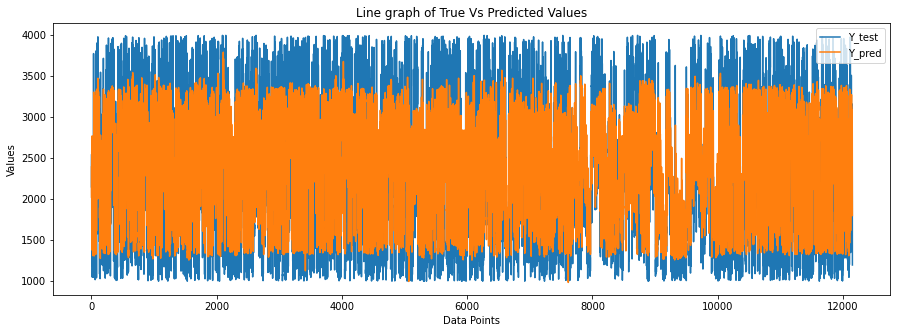

In [ ]:
fig, axes = plt.subplots(1, 1, sharex=True, sharey=True,figsize=(15,5))
ax3 = axes
ax3.plot(Y_test, label='Y_test')
ax3.plot(Y_pred, label='Y_pred')
ax3.legend(loc='best')
ax3.set_title('Line graph of True Vs Predicted Values')
ax3.set_xlabel('Data Points')
ax3.set_ylabel('Values')
plt.show()

In [ ]:
Y_test=Y_test['DL_bitrate']

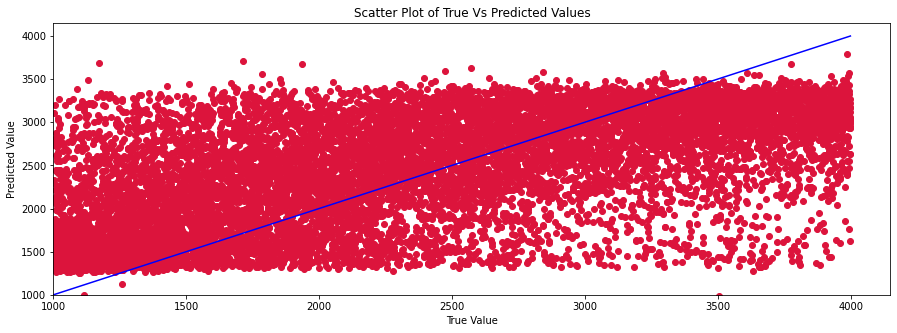

In [ ]:
fig, axes = plt.subplots(1, 1, sharex=True, sharey=True,figsize=(15,5))
ax3 = axes
ax3.scatter(Y_test, Y_pred[15], c='crimson')
p1 = max(max(Y_pred[15]), max(Y_test))
p2 = min(min(Y_pred[15]), min(Y_test))
ax3.plot([p1, p2], [p1, p2], 'b-')
ax3.set(xlim=(1000, None),ylim=(1000, None), title='Scatter Plot of True Vs Predicted Values', xlabel='True Value', ylabel='Predicted Value')
plt.show()

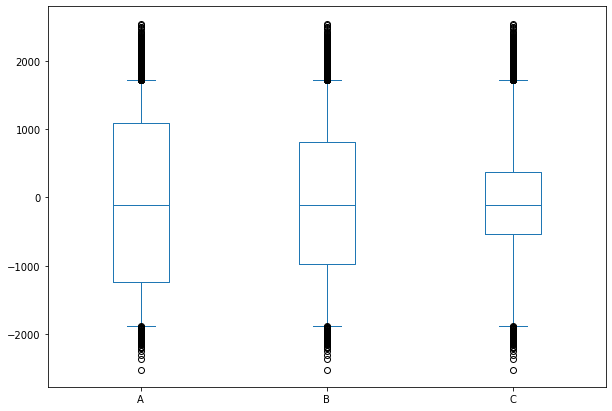

In [ ]:
a=Y_test.subtract(Y_pred[15])
stats = {}
# Compute the boxplot stats (as in the default matplotlib implementation)
stats['A'] = cbook.boxplot_stats(a, labels='A')[0]
stats['B'] = cbook.boxplot_stats(a, labels='B')[0]
stats['C'] = cbook.boxplot_stats(a, labels='C')[0]

# For box A compute the 1st and 99th percentiles
stats['A']['q1'], stats['A']['q3'] = np.percentile(a, [5, 95])
# For box B compute the 10th and 90th percentiles
stats['B']['q1'], stats['B']['q3'] = np.percentile(a, [10, 90])
# For box C compute the 25th and 75th percentiles (matplotlib default)
stats['C']['q1'], stats['C']['q3'] = np.percentile(a, [25, 75])

#fig = plt.figure(figsize =(10, 7))
fig, ax = plt.subplots(1, 1, figsize = (10,7))
# Plot boxplots from our computed statistics
bp = ax.bxp([stats['A'], stats['B'], stats['C']], positions=range(3))

# Colour the lines in the boxplot blue
for element in bp.keys():
    plt.setp(bp[element], color='C0')

In [ ]:
Y_pred=Y_pred[15]

In [ ]:
# calculate MAE
error = mae(Y_test, Y_pred)

# display
print("Mean absolute error : " + str(error))
print(f"Decimal Representation: {error:.20f}")

Mean absolute error : tf.Tensor(561.6943359375, shape=(), dtype=float64)
Decimal Representation: 561.69433593750000000000


In [ ]:
# Relative Absolute Error
# (|y1-y2|)/(|y1_mean-y1|)
def relative_absolute_error(y_true, y_pred):
  y1=y_true.to_numpy()
  y2=y_pred.to_numpy()
  num = np.sum(np.absolute(np.array(y1) - np.array(y2)))
  deno = np.sum(np.absolute(y2-np.mean(y1)))
  return (num/deno)
relative_absolute_error(Y_test, Y_pred)

0.9955447597917134

In [ ]:
# Root Relative Squared Error
# (|y1-y2|^2)/(|y1_mean-y1|^2)
def rrse(y_true, y_pred):
  y1=y_true.to_numpy()
  y2=y_pred.to_numpy()
  num = np.sum(np.square(np.absolute(np.array(y1) - np.array(y2))))
  deno = np.sum(np.square(np.absolute(y2-np.mean(y1))))
  return (num/deno)
rrse(Y_test, Y_pred)

1.2344420313982243

## High Throughput

In [ ]:
frame_high_train = frame_high.sample(frac = 0.7, random_state=0)
frame_high_test = frame_high.drop(frame_high_train.index)

In [ ]:
frame_high_train.head()

,CQI-0,CQI-1,CQI-2,CQI-3,CQI-4,DL_bitrate-0,DL_bitrate-1,DL_bitrate-2,DL_bitrate-3,DL_bitrate-4,...,SNR-1,SNR-2,SNR-3,SNR-4,UL_bitrate-0,UL_bitrate-1,UL_bitrate-2,UL_bitrate-3,UL_bitrate-4,DL_bitrate
86653,10.0,7.0,7.0,7.0,7.0,17268.0,17827.0,20354.0,19370.0,17525.0,...,7.0,7.0,7.0,7.0,320.0,359.0,371.0,357.0,355.0,13169.0
49814,9.0,9.0,9.0,11.0,12.0,42443.0,35699.0,41794.0,42219.0,39300.0,...,13.0,15.0,15.0,16.0,354.0,329.0,316.0,321.0,306.0,39709.0
14256,2.0,2.0,2.0,2.0,2.0,10736.0,14080.0,13633.0,14371.0,8399.0,...,2.0,2.0,1.0,1.0,300.0,264.0,254.0,267.0,159.0,7052.0
115838,5.0,5.0,5.0,5.0,2.0,6822.0,5715.0,5715.0,5715.0,5413.0,...,-8.0,-7.0,-6.0,-7.0,126.0,106.0,106.0,106.0,100.0,8159.0
107789,9.0,7.0,7.0,6.0,6.0,18229.0,19954.0,21887.0,20936.0,20421.0,...,4.0,4.0,3.0,3.0,330.0,367.0,404.0,389.0,372.0,18745.0


In [ ]:
frame_high_test.head()

,CQI-0,CQI-1,CQI-2,CQI-3,CQI-4,DL_bitrate-0,DL_bitrate-1,DL_bitrate-2,DL_bitrate-3,DL_bitrate-4,...,SNR-1,SNR-2,SNR-3,SNR-4,UL_bitrate-0,UL_bitrate-1,UL_bitrate-2,UL_bitrate-3,UL_bitrate-4,DL_bitrate
249,9.0,9.0,9.0,9.0,9.0,3836.0,1532.0,1644.0,1308.0,1151.0,...,4.0,4.0,2.0,2.0,71.0,29.0,31.0,25.0,21.0,6305.0
254,8.0,8.0,8.0,8.0,8.0,7661.0,6654.0,5334.0,5334.0,6542.0,...,6.0,5.0,6.0,4.0,141.0,123.0,99.0,99.0,121.0,9810.0
257,8.0,8.0,8.0,8.0,8.0,11508.0,9450.0,7616.0,7661.0,6654.0,...,5.0,5.0,5.0,6.0,213.0,457.0,203.0,141.0,123.0,7562.0
260,9.0,9.0,8.0,8.0,8.0,5737.0,8018.0,12458.0,11508.0,9450.0,...,5.0,5.0,5.0,5.0,149.0,147.0,244.0,213.0,457.0,4540.0
283,6.0,6.0,6.0,2.0,6.0,2225.0,0.0,1744.0,1252.0,257.0,...,-6.0,-11.0,-11.0,-5.0,70.0,0.0,92.0,61.0,11.0,7790.0


### With Scaling

#### MinMax Scaler

In [ ]:
df = frame_high_train[col_names_scaled]
min_max_scaler = MinMaxScaler()
# transform data
df_min_max_scaled = pd.DataFrame(min_max_scaler.fit_transform(df))

In [ ]:
X_train_min_max_scaler, X_valid_min_max_scaler, Y_train_min_max_scaler, Y_valid_min_max_scaler = train_test_split(df_min_max_scaled.iloc[:,:-1], df_min_max_scaled.iloc[:,-1:], test_size=0.3, random_state=0)
print('Train set shape', X_train_min_max_scaler.shape)
print('Validation set shape', X_valid_min_max_scaler.shape)
X_train_min_max_scaler.head()

Train set shape (48963, 15)
Validation set shape (20985, 15)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
22497,0.785714,0.642857,0.642857,0.642857,0.642857,0.257807,0.243157,0.267362,0.240879,0.259084,0.644940,0.604167,0.520833,0.520833,0.562500
62818,0.714286,0.642857,0.714286,0.571429,0.642857,0.179802,0.195600,0.224791,0.204912,0.262291,0.644940,0.604167,0.604167,0.604167,0.562500
33446,0.928571,0.785714,1.000000,1.000000,0.642857,0.490928,0.467356,0.498718,0.486232,0.402649,0.831814,0.812500,0.770833,0.770833,0.645833
43763,0.642857,0.642857,0.642857,0.642857,0.642857,0.021448,0.021975,0.021129,0.032639,0.022756,0.532816,0.479167,0.479167,0.479167,0.479167
60154,0.464193,0.452135,0.457127,0.450656,0.442259,0.057241,0.061081,0.070331,0.070716,0.074626,0.579834,0.502002,0.475187,0.483266,0.468724


In [ ]:
X_train_min_max_series = X_train_min_max_scaler.values.reshape((X_train_min_max_scaler.shape[0], X_train_min_max_scaler.shape[1], 1))
X_valid_min_max_series = X_valid_min_max_scaler.values.reshape((X_valid_min_max_scaler.shape[0], X_valid_min_max_scaler.shape[1], 1))
print('Train set shape', X_train_min_max_series.shape)
print('Validation set shape', X_valid_min_max_series.shape)

Train set shape (48963, 15, 1)
Validation set shape (20985, 15, 1)


### Hyper Parameter Tuning using Keras Auto Tuner

In [ ]:
mae = MeanAbsoluteError()
model_high = keras.Sequential()
model_high.add(keras.layers.Flatten(input_shape=(X_train_min_max_series.shape[1], X_train_min_max_series.shape[2])))
model_high.add(Dense(units=256, activation='relu'))
model_high.add(Dropout(rate=0))
model_high.add(tf.keras.layers.Dense(units=384, activation='relu'))
model_high.add(Dropout(rate=0))
model_high.add(tf.keras.layers.Dense(units=128, activation='relu'))
model_high.add(Dropout(rate=0))
model_high.add(Dense(1, kernel_initializer='normal', activation='linear'))
model_high.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),loss=mae,metrics=[mae])
model_high.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 15)                0         
                                                                 
 dense_8 (Dense)             (None, 256)               4096      
                                                                 
 dropout_6 (Dropout)         (None, 256)               0         
                                                                 
 dense_9 (Dense)             (None, 384)               98688     
                                                                 
 dropout_7 (Dropout)         (None, 384)               0         
                                                                 
 dense_10 (Dense)            (None, 128)               49280     
                                                                 
 dropout_8 (Dropout)         (None, 128)              

In [ ]:
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=30, 
        verbose=1, mode='auto', restore_best_weights=True)
history=model_high.fit(X_train_min_max_series, Y_train_min_max_scaler, validation_data=(X_valid_min_max_series, Y_valid_min_max_scaler),
        callbacks=[monitor],verbose=1,epochs=500)

Epoch 1/500
1531/1531 [==============================] - 5s 3ms/step - loss: 0.0275 - mean_absolute_error: 0.0275 - val_loss: 0.0249 - val_mean_absolute_error: 0.0249
Epoch 2/500
1531/1531 [==============================] - 5s 3ms/step - loss: 0.0250 - mean_absolute_error: 0.0250 - val_loss: 0.0260 - val_mean_absolute_error: 0.0260
Epoch 3/500
1531/1531 [==============================] - 6s 4ms/step - loss: 0.0250 - mean_absolute_error: 0.0250 - val_loss: 0.0249 - val_mean_absolute_error: 0.0249
Epoch 4/500
1531/1531 [==============================] - 6s 4ms/step - loss: 0.0249 - mean_absolute_error: 0.0249 - val_loss: 0.0250 - val_mean_absolute_error: 0.0250
Epoch 5/500
1531/1531 [==============================] - 5s 3ms/step - loss: 0.0247 - mean_absolute_error: 0.0247 - val_loss: 0.0247 - val_mean_absolute_error: 0.0247
Epoch 6/500
1531/1531 [==============================] - 5s 3ms/step - loss: 0.0247 - mean_absolute_error: 0.0247 - val_loss: 0.0253 - val_mean_absolute_error: 0.025

In [ ]:
kt_train_pred_min_max_scaled = model_high.predict(X_train_min_max_scaler)
kt_valid_pred_min_max_scaled = model_high.predict(X_valid_min_max_scaler)
print('Train rmse:', np.sqrt(mean_squared_error(Y_train_min_max_scaler, kt_train_pred_min_max_scaled)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_valid_min_max_scaler, kt_valid_pred_min_max_scaled)))

Train rmse: 0.039557427160101556
Validation rmse: 0.039770169044742086


In [ ]:
df = frame_high_test[col_names_scaled]
df_test_scaled = pd.DataFrame(min_max_scaler.fit_transform(df))
X_test_scaled = df_test_scaled.iloc[:,:-1]
X_test_scaled.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,0.571429,0.571429,0.571429,0.571429,0.571429,0.022171,0.009448,0.009502,0.008066,0.006653,0.416667,0.416667,0.416667,0.375000,0.375000
1,0.500000,0.500000,0.500000,0.500000,0.500000,0.044279,0.041035,0.030830,0.032894,0.037812,0.437500,0.458333,0.437500,0.458333,0.416667
2,0.500000,0.500000,0.500000,0.500000,0.500000,0.066514,0.058277,0.044019,0.047245,0.038459,0.437500,0.437500,0.437500,0.437500,0.458333
3,0.571429,0.571429,0.500000,0.500000,0.500000,0.033159,0.049446,0.072005,0.070969,0.054619,0.479167,0.437500,0.437500,0.437500,0.437500
4,0.357143,0.357143,0.357143,0.071429,0.357143,0.012860,0.000000,0.010080,0.007721,0.001485,0.208333,0.208333,0.104167,0.104167,0.229167


In [ ]:
Y_test = frame_high_test.iloc[:,-1:]
Y_test.reset_index(drop=True,inplace=True)
X_pred_scaled = model_high.predict(X_test_scaled)
df_test_scaled[15]=X_pred_scaled
#Inverse Transforming the Predicted Values
df_test = pd.DataFrame(min_max_scaler.inverse_transform(df_test_scaled))
Y_pred = df_test.iloc[:,-1:]

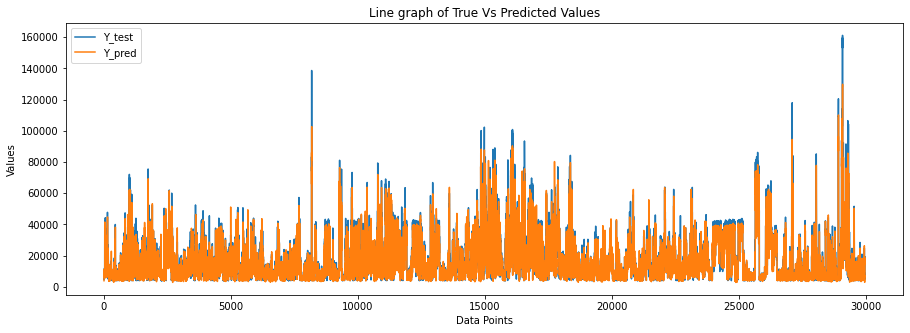

In [ ]:
fig, axes = plt.subplots(1, 1, sharex=True, sharey=True,figsize=(15,5))
ax3 = axes
ax3.plot(Y_test, label='Y_test')
ax3.plot(Y_pred, label='Y_pred')
ax3.legend(loc='best')
ax3.set_title('Line graph of True Vs Predicted Values')
ax3.set_xlabel('Data Points')
ax3.set_ylabel('Values')
plt.show()

In [ ]:
Y_test=Y_test['DL_bitrate']

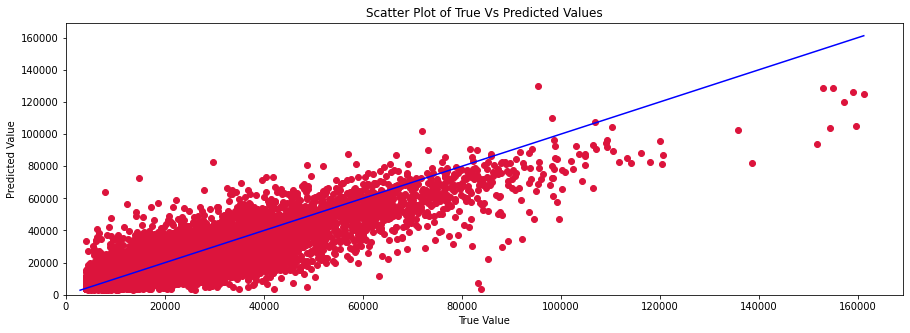

In [ ]:
fig, axes = plt.subplots(1, 1, sharex=True, sharey=True,figsize=(15,5))
ax3 = axes
ax3.scatter(Y_test, Y_pred[15], c='crimson')
p1 = max(max(Y_pred[15]), max(Y_test))
p2 = min(min(Y_pred[15]), min(Y_test))
ax3.plot([p1, p2], [p1, p2], 'b-')
ax3.set(xlim=(0, None),ylim=(0, None), title='Scatter Plot of True Vs Predicted Values', xlabel='True Value', ylabel='Predicted Value')
plt.show()

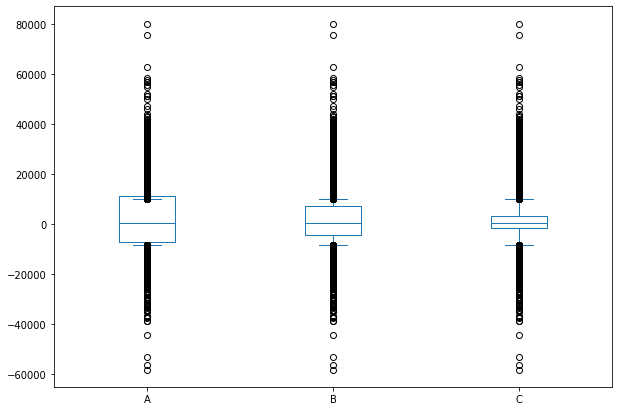

In [ ]:
a=Y_test.subtract(Y_pred[15])
stats = {}
# Compute the boxplot stats (as in the default matplotlib implementation)
stats['A'] = cbook.boxplot_stats(a, labels='A')[0]
stats['B'] = cbook.boxplot_stats(a, labels='B')[0]
stats['C'] = cbook.boxplot_stats(a, labels='C')[0]

# For box A compute the 1st and 99th percentiles
stats['A']['q1'], stats['A']['q3'] = np.percentile(a, [5, 95])
# For box B compute the 10th and 90th percentiles
stats['B']['q1'], stats['B']['q3'] = np.percentile(a, [10, 90])
# For box C compute the 25th and 75th percentiles (matplotlib default)
stats['C']['q1'], stats['C']['q3'] = np.percentile(a, [25, 75])

#fig = plt.figure(figsize =(10, 7))
fig, ax = plt.subplots(1, 1, figsize = (10,7))
# Plot boxplots from our computed statistics
bp = ax.bxp([stats['A'], stats['B'], stats['C']], positions=range(3))

# Colour the lines in the boxplot blue
for element in bp.keys():
    plt.setp(bp[element], color='C0')

In [ ]:
Y_pred=Y_pred[15]

In [ ]:
# calculate MAE
error = mae(Y_test, Y_pred)

# display
print("Mean absolute error : " + str(error))
print(f"Decimal Representation: {error:.20f}")

Mean absolute error : tf.Tensor(3935.676513671875, shape=(), dtype=float64)
Decimal Representation: 3935.67651367187500000000


In [ ]:
# Relative Absolute Error
# (|y1-y2|)/(|y1_mean-y1|)
def relative_absolute_error(y_true, y_pred):
  y1=y_true.to_numpy()
  y2=y_pred.to_numpy()
  num = np.sum(np.absolute(np.array(y1) - np.array(y2)))
  deno = np.sum(np.absolute(y2-np.mean(y1)))
  return (num/deno)
relative_absolute_error(Y_test, Y_pred)

0.39289005139694166

In [ ]:
# Root Relative Squared Error
# (|y1-y2|^2)/(|y1_mean-y1|^2)
def rrse(y_true, y_pred):
  y1=y_true.to_numpy()
  y2=y_pred.to_numpy()
  num = np.sum(np.square(np.absolute(np.array(y1) - np.array(y2))))
  deno = np.sum(np.square(np.absolute(y2-np.mean(y1))))
  return (num/deno)
rrse(Y_test, Y_pred)

0.23031095903147542

# Without Throughput Split

In [ ]:
frame.shape

(173308, 46)

In [ ]:
frame_train = frame.sample(frac = 0.7, random_state=0)
frame_test = frame.drop(frame_train.index)

In [ ]:
frame_train.head()

,CQI-0,CQI-1,CQI-2,CQI-3,CQI-4,DL_bitrate-0,DL_bitrate-1,DL_bitrate-2,DL_bitrate-3,DL_bitrate-4,...,SNR-1,SNR-2,SNR-3,SNR-4,UL_bitrate-0,UL_bitrate-1,UL_bitrate-2,UL_bitrate-3,UL_bitrate-4,DL_bitrate
49904,10.000000,9.000000,9.000000,8.000000,12.000000,47039.0,38774.0,42420.0,53247.0,41772.0,...,11.000000,11.000000,14.000000,14.000000,547.0,413.0,460.0,532.0,369.0,25897.0
10432,11.000000,11.000000,10.000000,11.000000,12.000000,46245.0,48628.0,53884.0,53314.0,53146.0,...,15.000000,14.000000,14.000000,14.000000,913.0,944.0,1065.0,1037.0,1050.0,48703.0
111290,8.000000,8.000000,5.000000,5.000000,9.000000,9025.0,4395.0,5144.0,6095.0,9159.0,...,2.000000,6.000000,6.000000,7.000000,228.0,151.0,234.0,102.0,169.0,3891.0
165744,7.355314,7.169824,7.048104,7.026775,7.117201,324.0,525.0,525.0,570.0,190.0,...,7.285093,6.673948,7.119487,7.265643,7.0,9.0,10.0,10.0,4.0,247.0
48759,5.000000,5.000000,5.000000,5.000000,5.000000,223.0,145.0,402.0,771.0,749.0,...,-8.000000,-8.000000,-6.000000,-6.000000,6.0,3.0,6.0,14.0,17.0,71.0


In [ ]:
frame_test.head()

,CQI-0,CQI-1,CQI-2,CQI-3,CQI-4,DL_bitrate-0,DL_bitrate-1,DL_bitrate-2,DL_bitrate-3,DL_bitrate-4,...,SNR-1,SNR-2,SNR-3,SNR-4,UL_bitrate-0,UL_bitrate-1,UL_bitrate-2,UL_bitrate-3,UL_bitrate-4,DL_bitrate
2,7.0,7.0,7.0,7.0,10.0,0.0,0.0,0.0,0.0,310.0,...,8.0,8.0,7.0,7.0,0.0,0.0,0.0,0.0,14.0,2549.0
4,9.0,9.0,7.0,7.0,7.0,4216.0,1757.0,0.0,0.0,0.0,...,10.0,10.0,8.0,8.0,151.0,68.0,0.0,0.0,0.0,2393.0
5,9.0,9.0,9.0,7.0,7.0,2874.0,4216.0,1757.0,0.0,0.0,...,10.0,10.0,10.0,8.0,53.0,151.0,68.0,0.0,0.0,2151.0
10,7.0,9.0,7.0,7.0,8.0,1666.0,2807.0,2382.0,1386.0,2516.0,...,9.0,9.0,12.0,10.0,60.0,52.0,45.0,26.0,47.0,2462.0
21,7.0,9.0,9.0,9.0,9.0,100.0,313.0,1107.0,156.0,2169.0,...,7.0,9.0,9.0,10.0,5.0,12.0,30.0,5.0,69.0,650.0


## MinMax Scaler

In [ ]:
df = frame_train[col_names_scaled]
min_max_scaler = MinMaxScaler()
# transform data
df_min_max_scaled = pd.DataFrame(min_max_scaler.fit_transform(df))

In [ ]:
X_train_min_max_scaler, X_valid_min_max_scaler, Y_train_min_max_scaler, Y_valid_min_max_scaler = train_test_split(df_min_max_scaled.iloc[:,:15], df_min_max_scaled.iloc[:,-1:], test_size=0.3, random_state=0)
print('Train set shape', X_train_min_max_scaler.shape)
print('Validation set shape', X_valid_min_max_scaler.shape)
X_train_min_max_scaler.head()

Train set shape (84921, 15)
Validation set shape (36395, 15)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
47723,0.424298,0.357143,0.285714,0.357143,0.366877,0.079894,0.051579,0.060973,0.082611,0.087004,0.412698,0.460317,0.460317,0.460317,0.455275
50990,0.529717,0.454226,0.446376,0.448897,0.467836,0.088038,0.089847,0.078942,0.078149,0.097864,0.625068,0.600131,0.588274,0.592658,0.589214
24873,0.517368,0.466327,0.461224,0.447100,0.461269,0.082738,0.116868,0.120002,0.096638,0.096638,0.626736,0.602633,0.588485,0.590768,0.589444
41093,0.488265,0.285714,0.428571,0.285714,0.296530,0.031673,0.018097,0.019582,0.044990,0.038008,0.444444,0.460317,0.460317,0.587302,0.580868
60737,0.552231,0.500000,0.500000,0.500000,0.507571,0.019582,0.016871,0.024763,0.028570,0.026628,0.555556,0.539683,0.539683,0.539683,0.533771


In [ ]:
X_train_min_max_series = X_train_min_max_scaler.values.reshape((X_train_min_max_scaler.shape[0], X_train_min_max_scaler.shape[1], 1))
X_valid_min_max_series = X_valid_min_max_scaler.values.reshape((X_valid_min_max_scaler.shape[0], X_valid_min_max_scaler.shape[1], 1))
print('Train set shape', X_train_min_max_series.shape)
print('Validation set shape', X_valid_min_max_series.shape)

Train set shape (84921, 15, 1)
Validation set shape (36395, 15, 1)


### Hyper Parameter Tuning using Keras Auto Tuner

In [ ]:
mae = MeanAbsoluteError()
model = keras.Sequential()
model.add(keras.layers.Flatten(input_shape=(X_train_min_max_series.shape[1], X_train_min_max_series.shape[2])))
model.add(Dense(units=256, activation='relu'))
model.add(Dropout(rate=0))
model.add(tf.keras.layers.Dense(units=384, activation='relu'))
model.add(Dropout(rate=0))
model.add(tf.keras.layers.Dense(units=128, activation='relu'))
model.add(Dropout(rate=0))
model.add(Dense(1, kernel_initializer='normal', activation='linear'))
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),loss=mae,metrics=[mae])
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_4 (Flatten)         (None, 15)                0         
                                                                 
 dense_16 (Dense)            (None, 256)               4096      
                                                                 
 dropout_12 (Dropout)        (None, 256)               0         
                                                                 
 dense_17 (Dense)            (None, 384)               98688     
                                                                 
 dropout_13 (Dropout)        (None, 384)               0         
                                                                 
 dense_18 (Dense)            (None, 128)               49280     
                                                                 
 dropout_14 (Dropout)        (None, 128)              

In [ ]:
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=30, 
        verbose=1, mode='auto', restore_best_weights=True)
history=model.fit(X_train_min_max_series, Y_train_min_max_scaler, validation_data=(X_valid_min_max_series, Y_valid_min_max_scaler),
        callbacks=[monitor],verbose=1,epochs=500)

Epoch 1/500
2654/2654 [==============================] - 10s 4ms/step - loss: 0.0179 - mean_absolute_error: 0.0179 - val_loss: 0.0166 - val_mean_absolute_error: 0.0166
Epoch 2/500
2654/2654 [==============================] - 9s 3ms/step - loss: 0.0168 - mean_absolute_error: 0.0168 - val_loss: 0.0166 - val_mean_absolute_error: 0.0166
Epoch 3/500
2654/2654 [==============================] - 8s 3ms/step - loss: 0.0166 - mean_absolute_error: 0.0166 - val_loss: 0.0166 - val_mean_absolute_error: 0.0166
Epoch 4/500
2654/2654 [==============================] - 10s 4ms/step - loss: 0.0166 - mean_absolute_error: 0.0166 - val_loss: 0.0176 - val_mean_absolute_error: 0.0176
Epoch 5/500
2654/2654 [==============================] - 9s 3ms/step - loss: 0.0165 - mean_absolute_error: 0.0165 - val_loss: 0.0181 - val_mean_absolute_error: 0.0181
Epoch 6/500
2654/2654 [==============================] - 9s 3ms/step - loss: 0.0164 - mean_absolute_error: 0.0164 - val_loss: 0.0164 - val_mean_absolute_error: 0.0

In [ ]:
kt_train_pred_min_max_scaled = model.predict(X_train_min_max_scaler)
kt_valid_pred_min_max_scaled = model.predict(X_valid_min_max_scaler)
print('Train rmse:', np.sqrt(mean_squared_error(Y_train_min_max_scaler, kt_train_pred_min_max_scaled)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_valid_min_max_scaler, kt_valid_pred_min_max_scaled)))

Train rmse: 0.03021754275531583
Validation rmse: 0.030412468463916435


In [ ]:
df = frame_test[col_names_scaled]
df_test_scaled = pd.DataFrame(min_max_scaler.fit_transform(df))
X_test_scaled = df_test_scaled.iloc[:,:-1]
X_test_scaled.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,0.428571,0.428571,0.428571,0.428571,0.642857,0.000000,0.000000,0.000000,0.000000,0.001866,0.645161,0.622951,0.603175,0.587302,0.596774
1,0.571429,0.571429,0.428571,0.428571,0.428571,0.027009,0.010835,0.000000,0.000000,0.000000,0.645161,0.655738,0.634921,0.603175,0.612903
2,0.571429,0.571429,0.571429,0.428571,0.428571,0.018412,0.026000,0.010155,0.000000,0.000000,0.645161,0.655738,0.634921,0.634921,0.612903
3,0.428571,0.571429,0.428571,0.428571,0.500000,0.010673,0.017310,0.013768,0.008628,0.015141,0.612903,0.639344,0.619048,0.666667,0.645161
4,0.428571,0.571429,0.571429,0.571429,0.571429,0.000641,0.001930,0.006398,0.000971,0.013053,0.596774,0.606557,0.619048,0.619048,0.645161


In [ ]:
Y_test = frame_test.iloc[:,-1:]
Y_test.reset_index(drop=True,inplace=True)
X_pred_scaled = model.predict(X_test_scaled)
df_test_scaled[15]=X_pred_scaled
#Inverse Transforming the Predicted Values
df_test = pd.DataFrame(min_max_scaler.inverse_transform(df_test_scaled))
Y_pred = df_test.iloc[:,-1:]

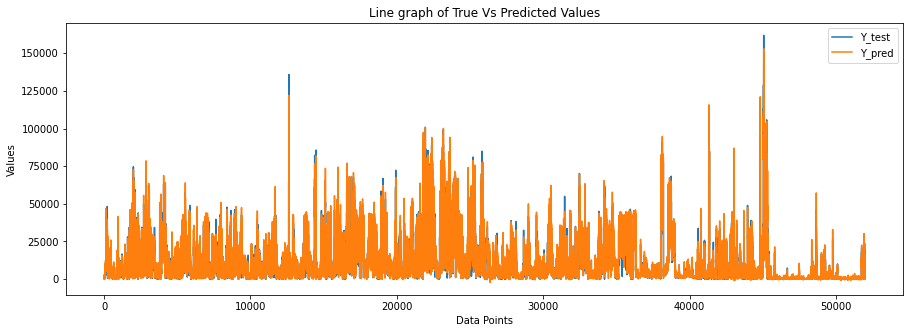

In [ ]:
fig, axes = plt.subplots(1, 1, sharex=True, sharey=True,figsize=(15,5))
ax3 = axes
ax3.plot(Y_test, label='Y_test')
ax3.plot(Y_pred, label='Y_pred')
ax3.legend(loc='best')
ax3.set_title('Line graph of True Vs Predicted Values')
ax3.set_xlabel('Data Points')
ax3.set_ylabel('Values')
plt.show()

In [ ]:
Y_test=Y_test['DL_bitrate']

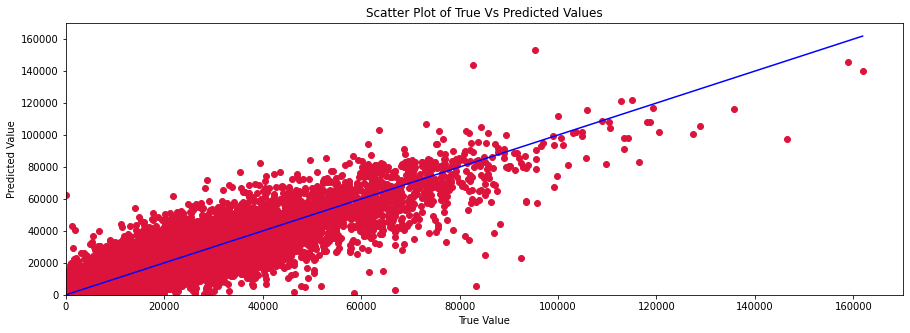

In [ ]:
fig, axes = plt.subplots(1, 1, sharex=True, sharey=True,figsize=(15,5))
ax3 = axes
ax3.scatter(Y_test, Y_pred[15], c='crimson')
p1 = max(max(Y_pred[15]), max(Y_test))
p2 = min(min(Y_pred[15]), min(Y_test))
ax3.plot([p1, p2], [p1, p2], 'b-')
ax3.set(xlim=(0, None),ylim=(0, None), title='Scatter Plot of True Vs Predicted Values', xlabel='True Value', ylabel='Predicted Value')
plt.show()

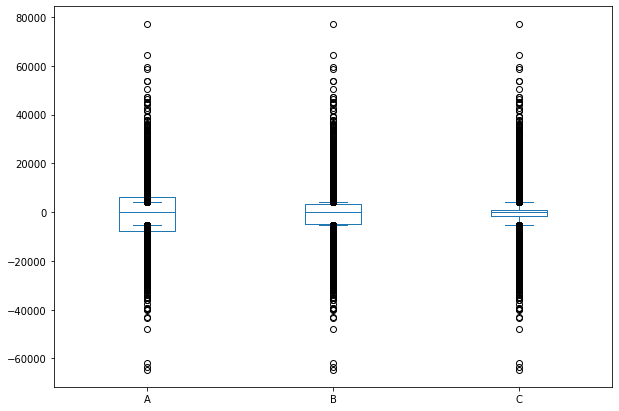

In [ ]:
import matplotlib.cbook as cbook
a=Y_test['DL_bitrate'].subtract(Y_pred[15])
stats = {}
# Compute the boxplot stats (as in the default matplotlib implementation)
stats['A'] = cbook.boxplot_stats(a, labels='A')[0]
stats['B'] = cbook.boxplot_stats(a, labels='B')[0]
stats['C'] = cbook.boxplot_stats(a, labels='C')[0]

# For box A compute the 1st and 99th percentiles
stats['A']['q1'], stats['A']['q3'] = np.percentile(a, [5, 95])
# For box B compute the 10th and 90th percentiles
stats['B']['q1'], stats['B']['q3'] = np.percentile(a, [10, 90])
# For box C compute the 25th and 75th percentiles (matplotlib default)
stats['C']['q1'], stats['C']['q3'] = np.percentile(a, [25, 75])

#fig = plt.figure(figsize =(10, 7))
fig, ax = plt.subplots(1, 1, figsize = (10,7))
# Plot boxplots from our computed statistics
bp = ax.bxp([stats['A'], stats['B'], stats['C']], positions=range(3))

# Colour the lines in the boxplot blue
for element in bp.keys():
    plt.setp(bp[element], color='C0')

In [ ]:
# calculate MAE
error = mae(Y_test, Y_pred)

# display
print("Mean absolute error : " + str(error))
print(f"Decimal Representation: {error:.20f}")

Mean absolute error : tf.Tensor(2676.46630859375, shape=(), dtype=float64)
Decimal Representation: 2676.46630859375000000000


In [ ]:
# Mean Absolute Percentage Error
error = mean_absolute_percentage_error(Y_test, Y_pred)
print(error)

print(f" {error:.5f}")

2.8639105684498932e+16
 28639105684498932.00000


In [ ]:
# Relative Absolute Error
# (|y1-y2|)/(|y1_mean-y1|)
def relative_absolute_error(y_true, y_pred):
  y1=y_true.to_numpy()
  y2=y_pred.to_numpy()
  num = np.sum(np.absolute(np.array(y1) - np.array(y2)))
  deno = np.sum(np.absolute(y2-np.mean(y1)))
  return (num/deno)
relative_absolute_error(Y_test, Y_pred)

0.2689981965884813

In [ ]:
# Root Relative Squared Error
# (|y1-y2|^2)/(|y1_mean-y1|^2)
def rrse(y_true, y_pred):
  y1=y_true.to_numpy()
  y2=y_pred.to_numpy()
  num = np.sum(np.square(np.absolute(np.array(y1) - np.array(y2))))
  deno = np.sum(np.square(np.absolute(y2-np.mean(y1))))
  return (num/deno)
rrse(Y_test, Y_pred)

0.12610235216348925

## Testing on SPlit Throughput

## Low Throughput

In [ ]:
df = frame_low_test[col_names_scaled]
df_test_scaled = pd.DataFrame(min_max_scaler.fit_transform(df))
X_test_scaled = df_test_scaled.iloc[:,:-1]
X_test_scaled.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,0.357143,0.428571,0.428571,0.500000,0.357143,0.014106,0.003666,0.002099,0.017551,0.009842,0.476190,0.507937,0.523810,0.507937,0.507937
1,0.357143,0.357143,0.428571,0.428571,0.500000,0.010619,0.015586,0.003666,0.001985,0.016543,0.476190,0.476190,0.507937,0.523810,0.507937
2,0.357143,0.357143,0.357143,0.357143,0.428571,0.013468,0.000172,0.011733,0.014737,0.003267,0.492063,0.492063,0.476190,0.476190,0.507937
3,0.428571,0.428571,0.357143,0.357143,0.500000,0.009825,0.009806,0.006470,0.008442,0.001871,0.476190,0.476190,0.492063,0.492063,0.492063
4,0.428571,0.428571,0.428571,0.428571,0.357143,0.009343,0.006830,0.010856,0.009272,0.005765,0.460317,0.460317,0.476190,0.476190,0.492063


In [ ]:
Y_test = frame_low_test.iloc[:,-1:]
Y_test.reset_index(drop=True,inplace=True)
X_pred_scaled = model.predict(X_test_scaled)
df_test_scaled[15]=X_pred_scaled
#Inverse Transforming the Predicted Values
df_test = pd.DataFrame(min_max_scaler.inverse_transform(df_test_scaled))
Y_pred = df_test.iloc[:,-1:]

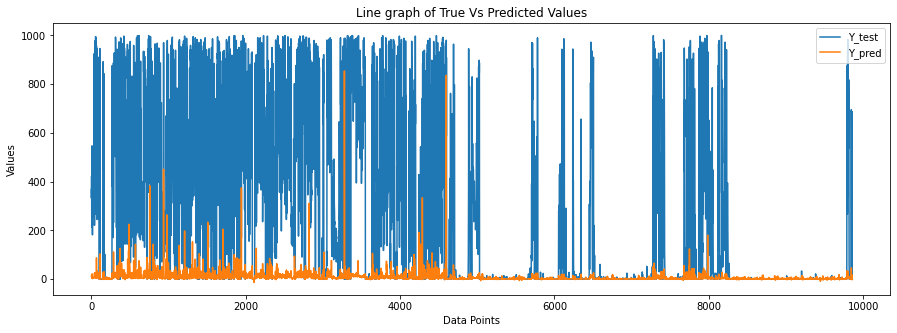

In [ ]:
fig, axes = plt.subplots(1, 1, sharex=True, sharey=True,figsize=(15,5))
ax3 = axes
ax3.plot(Y_test, label='Y_test')
ax3.plot(Y_pred, label='Y_pred')
ax3.legend(loc='best')
ax3.set_title('Line graph of True Vs Predicted Values')
ax3.set_xlabel('Data Points')
ax3.set_ylabel('Values')
plt.show()

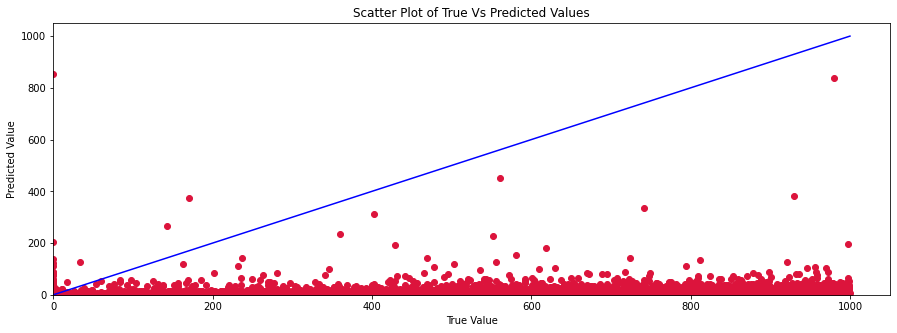

In [ ]:
fig, axes = plt.subplots(1, 1, sharex=True, sharey=True,figsize=(15,5))
ax3 = axes
ax3.scatter(Y_test, Y_pred[15], c='crimson')
p1 = max(max(Y_pred[15]), max(Y_test))
p2 = min(min(Y_pred[15]), min(Y_test))
ax3.plot([p1, p2], [p1, p2], 'b-')
ax3.set(xlim=(0, None),ylim=(0, None), title='Scatter Plot of True Vs Predicted Values', xlabel='True Value', ylabel='Predicted Value')
plt.show()

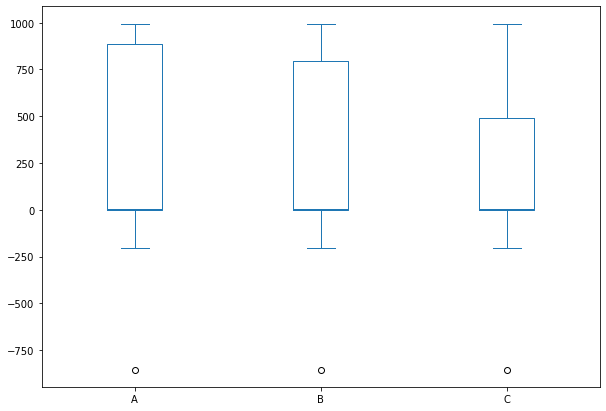

In [ ]:
a=Y_test.subtract(Y_pred[15])
stats = {}
# Compute the boxplot stats (as in the default matplotlib implementation)
stats['A'] = cbook.boxplot_stats(a, labels='A')[0]
stats['B'] = cbook.boxplot_stats(a, labels='B')[0]
stats['C'] = cbook.boxplot_stats(a, labels='C')[0]

# For box A compute the 1st and 99th percentiles
stats['A']['q1'], stats['A']['q3'] = np.percentile(a, [5, 95])
# For box B compute the 10th and 90th percentiles
stats['B']['q1'], stats['B']['q3'] = np.percentile(a, [10, 90])
# For box C compute the 25th and 75th percentiles (matplotlib default)
stats['C']['q1'], stats['C']['q3'] = np.percentile(a, [25, 75])

#fig = plt.figure(figsize =(10, 7))
fig, ax = plt.subplots(1, 1, figsize = (10,7))
# Plot boxplots from our computed statistics
bp = ax.bxp([stats['A'], stats['B'], stats['C']], positions=range(3))

# Colour the lines in the boxplot blue
for element in bp.keys():
    plt.setp(bp[element], color='C0')

In [ ]:
Y_pred=Y_pred[15]

In [ ]:
# calculate MAE
error = mae(Y_test, Y_pred)

# display
print("Mean absolute error : " + str(error))
print(f"Decimal Representation: {error:.20f}")

Mean absolute error : tf.Tensor(247.83697509765625, shape=(), dtype=float64)
Decimal Representation: 247.83697509765625000000


In [ ]:
# Relative Absolute Error
# (|y1-y2|)/(|y1_mean-y1|)
def relative_absolute_error(y_true, y_pred):
  y1=y_true.to_numpy()
  y2=y_pred.to_numpy()
  num = np.sum(np.absolute(np.array(y1) - np.array(y2)))
  deno = np.sum(np.absolute(y2-np.mean(y1)))
  return (num/deno)
relative_absolute_error(Y_test, Y_pred)

1.0093255427500967

In [ ]:
# Root Relative Squared Error
# (|y1-y2|^2)/(|y1_mean-y1|^2)
def rrse(y_true, y_pred):
  y1=y_true.to_numpy()
  y2=y_pred.to_numpy()
  num = np.sum(np.square(np.absolute(np.array(y1) - np.array(y2))))
  deno = np.sum(np.square(np.absolute(y2-np.mean(y1))))
  return (num/deno)
rrse(Y_test, Y_pred)

2.708069252346407

## Medium Throughput

In [ ]:
df = frame_medium_test[col_names_scaled]
df_test_scaled = pd.DataFrame(min_max_scaler.fit_transform(df))
X_test_scaled = df_test_scaled.iloc[:,:-1]
X_test_scaled.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,0.571429,0.571429,0.571429,0.428571,0.428571,0.069228,0.101554,0.035975,0.000000,0.000000,0.645491,0.615154,0.615547,0.605350,0.534485
1,0.428571,0.571429,0.428571,0.428571,0.500000,0.040130,0.067614,0.048771,0.030007,0.026884,0.606102,0.595912,0.595313,0.646892,0.575278
2,0.428571,0.428571,0.571429,0.428571,0.428571,0.026665,0.040130,0.057473,0.051571,0.014810,0.606102,0.576670,0.595313,0.584579,0.616070
3,0.428571,0.428571,0.428571,0.428571,0.571429,0.052246,0.092111,0.022666,0.036069,0.029993,0.606102,0.576670,0.575078,0.563808,0.554881
4,0.571429,0.428571,0.428571,0.428571,0.428571,0.069228,0.052246,0.078296,0.023967,0.017802,0.625797,0.576670,0.575078,0.563808,0.534485


In [ ]:
Y_test = frame_medium_test.iloc[:,-1:]
Y_test.reset_index(drop=True,inplace=True)
X_pred_scaled = model.predict(X_test_scaled)
df_test_scaled[15]=X_pred_scaled
#Inverse Transforming the Predicted Values
df_test = pd.DataFrame(min_max_scaler.inverse_transform(df_test_scaled))
Y_pred = df_test.iloc[:,-1:]

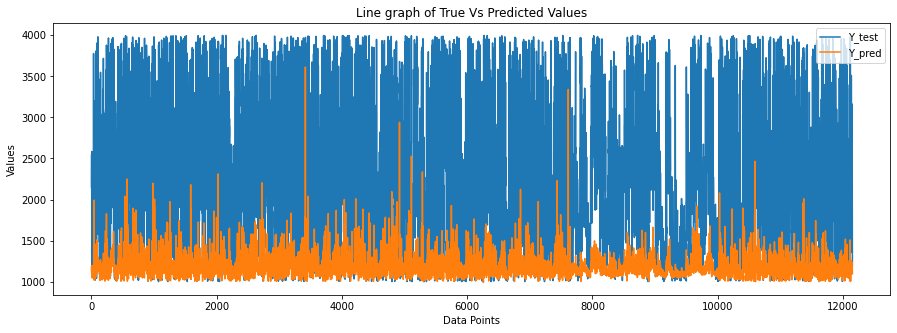

In [ ]:
fig, axes = plt.subplots(1, 1, sharex=True, sharey=True,figsize=(15,5))
ax3 = axes
ax3.plot(Y_test, label='Y_test')
ax3.plot(Y_pred, label='Y_pred')
ax3.legend(loc='best')
ax3.set_title('Line graph of True Vs Predicted Values')
ax3.set_xlabel('Data Points')
ax3.set_ylabel('Values')
plt.show()

In [ ]:
Y_test=Y_test['DL_bitrate']

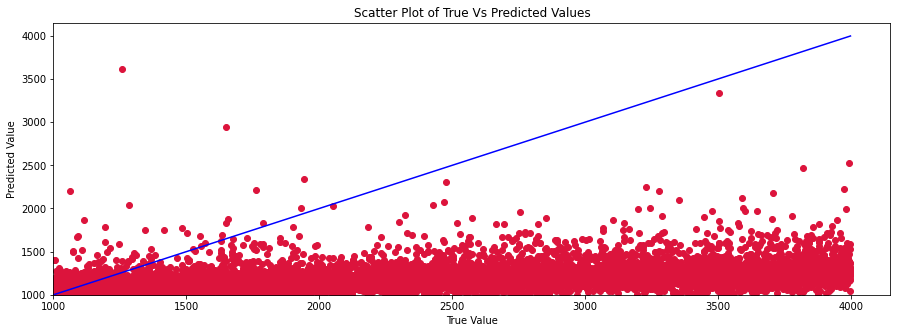

In [ ]:
fig, axes = plt.subplots(1, 1, sharex=True, sharey=True,figsize=(15,5))
ax3 = axes
ax3.scatter(Y_test, Y_pred[15], c='crimson')
p1 = max(max(Y_pred[15]), max(Y_test))
p2 = min(min(Y_pred[15]), min(Y_test))
ax3.plot([p1, p2], [p1, p2], 'b-')
ax3.set(xlim=(1000, None),ylim=(1000, None), title='Scatter Plot of True Vs Predicted Values', xlabel='True Value', ylabel='Predicted Value')
plt.show()

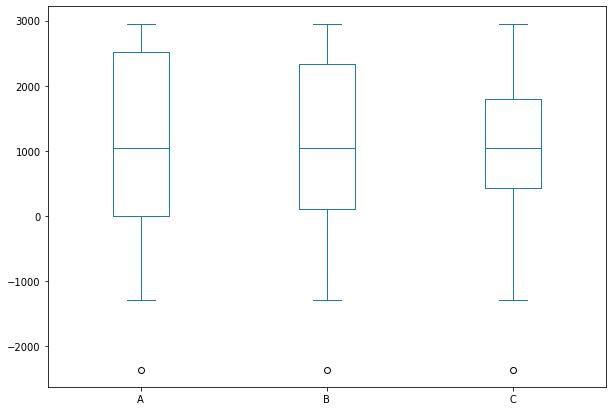

In [ ]:
a=Y_test.subtract(Y_pred[15])
stats = {}
# Compute the boxplot stats (as in the default matplotlib implementation)
stats['A'] = cbook.boxplot_stats(a, labels='A')[0]
stats['B'] = cbook.boxplot_stats(a, labels='B')[0]
stats['C'] = cbook.boxplot_stats(a, labels='C')[0]

# For box A compute the 1st and 99th percentiles
stats['A']['q1'], stats['A']['q3'] = np.percentile(a, [5, 95])
# For box B compute the 10th and 90th percentiles
stats['B']['q1'], stats['B']['q3'] = np.percentile(a, [10, 90])
# For box C compute the 25th and 75th percentiles (matplotlib default)
stats['C']['q1'], stats['C']['q3'] = np.percentile(a, [25, 75])

#fig = plt.figure(figsize =(10, 7))
fig, ax = plt.subplots(1, 1, figsize = (10,7))
# Plot boxplots from our computed statistics
bp = ax.bxp([stats['A'], stats['B'], stats['C']], positions=range(3))

# Colour the lines in the boxplot blue
for element in bp.keys():
    plt.setp(bp[element], color='C0')

In [ ]:
Y_pred=Y_pred[15]

In [ ]:
# calculate MAE
error = mae(Y_test, Y_pred)

# display
print("Mean absolute error : " + str(error))
print(f"Decimal Representation: {error:.20f}")

Mean absolute error : tf.Tensor(1144.988037109375, shape=(), dtype=float64)
Decimal Representation: 1144.98803710937500000000


In [ ]:
# Relative Absolute Error
# (|y1-y2|)/(|y1_mean-y1|)
def relative_absolute_error(y_true, y_pred):
  y1=y_true.to_numpy()
  y2=y_pred.to_numpy()
  num = np.sum(np.absolute(np.array(y1) - np.array(y2)))
  deno = np.sum(np.absolute(y2-np.mean(y1)))
  return (num/deno)
relative_absolute_error(Y_test, Y_pred)

1.006730570299311

In [ ]:
# Root Relative Squared Error
# (|y1-y2|^2)/(|y1_mean-y1|^2)
def rrse(y_true, y_pred):
  y1=y_true.to_numpy()
  y2=y_pred.to_numpy()
  num = np.sum(np.square(np.absolute(np.array(y1) - np.array(y2))))
  deno = np.sum(np.square(np.absolute(y2-np.mean(y1))))
  return (num/deno)
rrse(Y_test, Y_pred)

1.4889058677917058

## High Throughput

In [ ]:
df = frame_high_test[col_names_scaled]
df_test_scaled = pd.DataFrame(min_max_scaler.fit_transform(df))
X_test_scaled = df_test_scaled.iloc[:,:-1]
X_test_scaled.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,0.571429,0.571429,0.571429,0.571429,0.571429,0.022171,0.009448,0.009502,0.008066,0.006653,0.416667,0.416667,0.416667,0.375000,0.375000
1,0.500000,0.500000,0.500000,0.500000,0.500000,0.044279,0.041035,0.030830,0.032894,0.037812,0.437500,0.458333,0.437500,0.458333,0.416667
2,0.500000,0.500000,0.500000,0.500000,0.500000,0.066514,0.058277,0.044019,0.047245,0.038459,0.437500,0.437500,0.437500,0.437500,0.458333
3,0.571429,0.571429,0.500000,0.500000,0.500000,0.033159,0.049446,0.072005,0.070969,0.054619,0.479167,0.437500,0.437500,0.437500,0.437500
4,0.357143,0.357143,0.357143,0.071429,0.357143,0.012860,0.000000,0.010080,0.007721,0.001485,0.208333,0.208333,0.104167,0.104167,0.229167


In [ ]:
Y_test = frame_high_test.iloc[:,-1:]
Y_test.reset_index(drop=True,inplace=True)
X_pred_scaled = model.predict(X_test_scaled)
df_test_scaled[15]=X_pred_scaled
#Inverse Transforming the Predicted Values
df_test = pd.DataFrame(min_max_scaler.inverse_transform(df_test_scaled))
Y_pred = df_test.iloc[:,-1:]

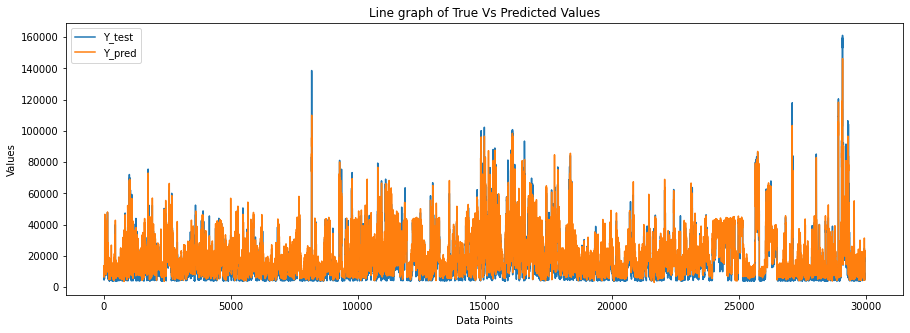

In [ ]:
fig, axes = plt.subplots(1, 1, sharex=True, sharey=True,figsize=(15,5))
ax3 = axes
ax3.plot(Y_test, label='Y_test')
ax3.plot(Y_pred, label='Y_pred')
ax3.legend(loc='best')
ax3.set_title('Line graph of True Vs Predicted Values')
ax3.set_xlabel('Data Points')
ax3.set_ylabel('Values')
plt.show()

In [ ]:
Y_test=Y_test['DL_bitrate']

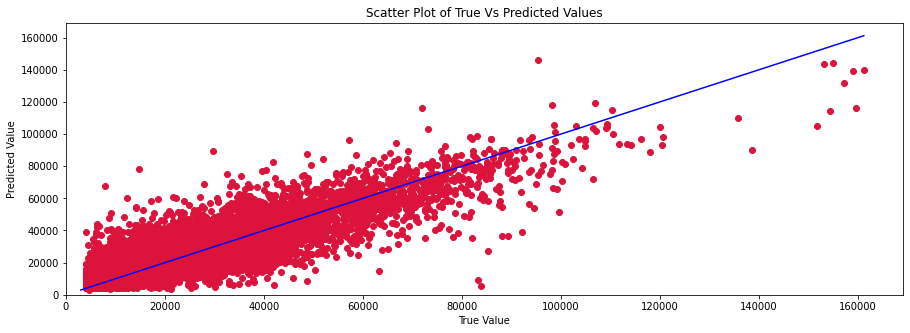

In [ ]:
fig, axes = plt.subplots(1, 1, sharex=True, sharey=True,figsize=(15,5))
ax3 = axes
ax3.scatter(Y_test, Y_pred[15], c='crimson')
p1 = max(max(Y_pred[15]), max(Y_test))
p2 = min(min(Y_pred[15]), min(Y_test))
ax3.plot([p1, p2], [p1, p2], 'b-')
ax3.set(xlim=(0, None),ylim=(0, None), title='Scatter Plot of True Vs Predicted Values', xlabel='True Value', ylabel='Predicted Value')
plt.show()

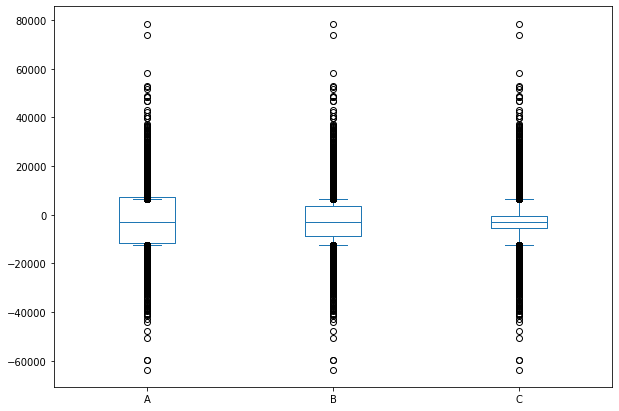

In [ ]:
a=Y_test.subtract(Y_pred[15])
stats = {}
# Compute the boxplot stats (as in the default matplotlib implementation)
stats['A'] = cbook.boxplot_stats(a, labels='A')[0]
stats['B'] = cbook.boxplot_stats(a, labels='B')[0]
stats['C'] = cbook.boxplot_stats(a, labels='C')[0]

# For box A compute the 1st and 99th percentiles
stats['A']['q1'], stats['A']['q3'] = np.percentile(a, [5, 95])
# For box B compute the 10th and 90th percentiles
stats['B']['q1'], stats['B']['q3'] = np.percentile(a, [10, 90])
# For box C compute the 25th and 75th percentiles (matplotlib default)
stats['C']['q1'], stats['C']['q3'] = np.percentile(a, [25, 75])

#fig = plt.figure(figsize =(10, 7))
fig, ax = plt.subplots(1, 1, figsize = (10,7))
# Plot boxplots from our computed statistics
bp = ax.bxp([stats['A'], stats['B'], stats['C']], positions=range(3))

# Colour the lines in the boxplot blue
for element in bp.keys():
    plt.setp(bp[element], color='C0')

In [ ]:
Y_pred=Y_pred[15]

In [ ]:
# calculate MAE
error = mae(Y_test, Y_pred)

# display
print("Mean absolute error : " + str(error))
print(f"Decimal Representation: {error:.20f}")

Mean absolute error : tf.Tensor(4966.4306640625, shape=(), dtype=float64)
Decimal Representation: 4966.43066406250000000000


In [ ]:
# Relative Absolute Error
# (|y1-y2|)/(|y1_mean-y1|)
def relative_absolute_error(y_true, y_pred):
  y1=y_true.to_numpy()
  y2=y_pred.to_numpy()
  num = np.sum(np.absolute(np.array(y1) - np.array(y2)))
  deno = np.sum(np.absolute(y2-np.mean(y1)))
  return (num/deno)
relative_absolute_error(Y_test, Y_pred)

0.5304369180811154

In [ ]:
# Root Relative Squared Error
# (|y1-y2|^2)/(|y1_mean-y1|^2)
def rrse(y_true, y_pred):
  y1=y_true.to_numpy()
  y2=y_pred.to_numpy()
  num = np.sum(np.square(np.absolute(np.array(y1) - np.array(y2))))
  deno = np.sum(np.square(np.absolute(y2-np.mean(y1))))
  return (num/deno)
rrse(Y_test, Y_pred)

0.2458723817207951